In [66]:
from ACLScheduleTest.Simulate import Simulator

In [76]:
Print_limit = 10
Epoch  = 0
Out_Epoch = 0
from dill.source import getsource
def schedule_in_func(workers, cache, av_mem, factor_node_dict, calculated_node_dict, dsk, global_dict):
    global  Print_limit, Epoch
    Epoch += 1
    if Print_limit >= Epoch:
        print('+'*60)

        print(f'in_func Info: Epoch {Epoch}\n')
        print(f'workers:调度其中各个workers的状态, 是一个词典(dict)')
        print('key是worker的名字，如\'worker_0\'; ')
        print('value有两种，如果该worker没有正在运行, 就输出None；如果正在计算某个节点node并且已经运行了1单位时间，则输出[\'node\', 1].\n 注意，在题目假设下，每个任务都以单位时间执行，因此这里只有可能出现0')
        for key in workers.keys():
            print(key, workers[key])


        print(f'\ncache:内存存储状态，存储各个节点内用于计算的数值。也是一个dict')
        print('key是节点node的名字，value是存储的具体数值')
        for key in cache.keys():
            print(key, cache[key])
        
        

        print(f'\nav_mem:当前状态下可用的内存，float格式\n{av_mem}')
        
        print(f'\nfactor_node_dict:因子节点的状态，key是node名字，value是输出数值，如果是None表示未被计算到')
        for key in factor_node_dict.keys():
            print(key, factor_node_dict[key])

        print(f'\ncalculated_node_dict:记录节点是否已经被计算完，value为bool格式. 在demo中未被用到\n')
        for key in calculated_node_dict.keys():
            print(key, calculated_node_dict[key])

        print(f'\ndsk:网络结构，运算的依赖关系\n')
        print('每个key是node的名字， value是一个元组，第一个值是要计算的lambda函数，后面为自变量')
        print('自变量可以是要计算的数值，也可以是其他node。')
        for key in dsk.keys():
            print(key, getsource(dsk[key][0].func), dsk[key][1:])

        print(f'\nglobal_dict在demo中未被用到。保留给选手可以自定义的参数。:\n{global_dict}')
        

    # 检查因子节点是否还有未计算的（None）。如果没有，表明所有因子节点都有计算结果，此时返回None并退出计算
    factor_node = set([k for k in factor_node_dict if factor_node_dict[k] is None])

    if len(factor_node) == 0:
        return None

    # 检查正在工作的worker，并将这些worker的正在计算的节点组成集合记为workers_nodes
    workers_nodes = set([workers[k][0] for k in workers if workers[k] is not None])

    def topoOrder():
        topoQueue = []
        q = list(factor_node - set(cache.keys()) - workers_nodes)

        nodeList = set(dsk.keys()) - set(factor_node)
        while len(q):
            node, q = q[0], q[1:]

            topoQueue.append(node)

            append_nodes = [arg for arg in dsk[node][1:] if
                            (arg in nodeList) and (arg not in cache.keys()) and (arg not in workers_nodes)]
            nodeList = nodeList - set(append_nodes)
            q = q + append_nodes
        return topoQueue

    topo_node = topoOrder()

    nodeList = dsk.keys()

    def available_node():
        for node in topo_node:
            if dsk[node][0].mem > av_mem:
                continue
            args = dsk[node][1:]
            isAvailable = True
            for arg in args:
                if (arg in nodeList) and (arg not in cache):
                    isAvailable = False
                    break
            if isAvailable:
                return node
        return None
    if Print_limit >= Epoch:


        print(f'\nreturn: 输出一个node，表示下一步即将调用于计算的worker，如果不能调用就返回None \n{available_node()}')
        print('+'*60, '\n'*5)


    return available_node()




In [77]:
def schedule_out_func(workers, cache, av_mem, factor_node_dict, calculated_node_dict, dsk, global_dict):
    global  Print_limit, Out_Epoch
    Out_Epoch += 1

    if Print_limit >= Out_Epoch:
        print('-'*60)
        print(f'out_func Info: Epoch {Out_Epoch}\n')
        print(f'out_func的自变量与in_func完全相同。但在默认函数中，只用到了workers, cache, factor_node_dict, dsk这四个')

    factor_node = set([k for k in factor_node_dict if factor_node_dict[k] is None])

    if len(factor_node) == 0:
        return []

    workers_nodes = set([workers[k][0] for k in workers if workers[k] is not None])

    def topoOrder():
        topoQueue = []
        q = list(factor_node - set(cache.keys()) - workers_nodes)

        nodeList = set(dsk.keys()) - set(factor_node)
        while len(q):
            node, q = q[0], q[1:]

            topoQueue.append(node)

            append_nodes = [arg for arg in dsk[node][1:] if
                            (arg in nodeList) and (arg not in cache.keys()) and (arg not in workers_nodes)]
            nodeList = nodeList - set(append_nodes)
            q = q + append_nodes
        return topoQueue

    topo_node = topoOrder()

    def trash_cache():
        trash_node = []

        for node in cache:
            isTrash = True
            for tp_node in topo_node + list(workers_nodes):
                if node in dsk[tp_node][1:]:
                    isTrash = False
                    break
            if isTrash:
                trash_node.append(node)
        return trash_node
    if Print_limit >= Out_Epoch:
        print(f'return:即将被清除出内存的节点\n{trash_cache()}')
        print('-'*60, '\n'*5)


    return trash_cache()

------------------------------------------------------------
out_func Info: Epoch 1

out_func的自变量与in_func完全相同。但在默认函数中，只用到了workers, cache, factor_node_dict, dsk这四个
return:即将被清除出内存的节点
[]
------------------------------------------------------------ 





++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
in_func Info: Epoch 1

workers:调度其中各个workers的状态, 是一个词典(dict)
key是worker的名字，如'worker_0'; 
value有两种，如果该worker没有正在运行, 就输出None；如果正在计算某个节点node并且已经运行了1单位时间，则输出['node', 1].
 注意，在题目假设下，每个任务都以单位时间执行，因此这里只有可能出现0
worker_0 None
worker_1 None
worker_2 None
worker_3 None
worker_4 None
worker_5 None
worker_6 None
worker_7 None
worker_8 None
worker_9 None

cache:内存存储状态，存储各个节点内用于计算的数值。也是一个dict
key是节点node的名字，value是存储的具体数值

av_mem:当前状态下可用的内存，float格式
50

factor_node_dict:因子节点的状态，key是node名字，value是输出数值，如果是None表示未被计算到
node83 None
node80 None
node99 None
node86 None
node94 None
node52 None
node82 None
node33 None
node60 None
node56 None
node66 None
node41 None
node89 None
node63 None
node95 None
node97

node3         lambda x, y, z: x * y + z,
 (0.09731241000203772, 0.8622193828246548, 0.6291766986698639)
node4         lambda x, y, z: x + y - z,
 (0.9497045626994913, 0.5988149290361087, 0.9141879873628219)
node5         lambda x, y: (x / y) if y != 0 else x,
 (0.992778175243325, 0.3608671799854394)
node6         lambda x, y, z: (x + y / z) if z != 0 else (x + y),
 (0.8533958615999857, 0.05502228824137867, 0.4051489232319011)
node7         lambda x, y: x * y,
 (0.4057964742149891, 0.7705370248657939)
node8         lambda x, y: (x / y) if y != 0 else x,
 (0.4439450850861413, 0.9850801649174358)
node9         lambda x, y, z: (x + y / z) if z != 0 else (x + y),
 (0.0416808665743581, 0.8736973982465172, 0.8413604768161272)
node10         lambda x: np.sqrt(max(x, 0.1)),
 ('node7',)
node11         lambda x, y: x * y,
 ('node3', 'node0')
node12         lambda x: np.sqrt(max(x, 0.1)),
 ('node4',)
node13         lambda x, y, z: x + y - z,
 ('node11', 'node9', 'node6')
node14         lambda x: (

 ('node0',)
node65         lambda x, y: x - y,
 ('node13', 'node51')
node66         lambda x, y: (x / y) if y != 0 else x,
 ('node55', 'node59')
node67         lambda x, y, z: x * y + z,
 ('node48', 'node36', 'node43')
node68         lambda x: (1. / x) if x != 0 else 0,
 ('node24',)
node69         lambda x, y, z: x * y + z,
 ('node65', 'node2', 'node4')
node70         lambda x, y, z: (x + y / z) if z != 0 else (x + y),
 ('node5', 'node16', 'node69')
node71         lambda x: (1. / x) if x != 0 else 0,
 ('node23',)
node72         lambda x, y, z: (x + y / z) if z != 0 else (x + y),
 ('node7', 'node6', 'node4')
node73         lambda x: x + 1
 ('node8',)
node74         lambda x, y: x - y,
 ('node4', 'node50')
node75         lambda x, y, z: x + y + z,
 ('node2', 'node70', 'node15')
node76         lambda x, y, z: x * y + z,
 ('node8', 'node57', 'node11')
node77         lambda x: x + 1
 ('node4',)
node78         lambda x: (1. / x) if x != 0 else 0,
 ('node73',)
node79         lambda x: x + 1
 

------------------------------------------------------------
out_func Info: Epoch 5

out_func的自变量与in_func完全相同。但在默认函数中，只用到了workers, cache, factor_node_dict, dsk这四个
return:即将被清除出内存的节点
['node53', 'node62']
------------------------------------------------------------ 





------------------------------------------------------------
out_func Info: Epoch 6

out_func的自变量与in_func完全相同。但在默认函数中，只用到了workers, cache, factor_node_dict, dsk这四个
return:即将被清除出内存的节点
['node29', 'node18', 'node33', 'node28']
------------------------------------------------------------ 





------------------------------------------------------------
out_func Info: Epoch 7

out_func的自变量与in_func完全相同。但在默认函数中，只用到了workers, cache, factor_node_dict, dsk这四个
return:即将被清除出内存的节点
['node73', 'node92', 'node34', 'node32', 'node46', 'node82', 'node21', 'node63', 'node93', 'node56', 'node68', 'node38', 'node35']
------------------------------------------------------------ 





------------------------------------------------------------

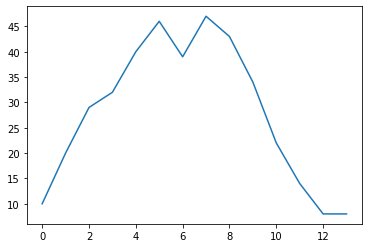

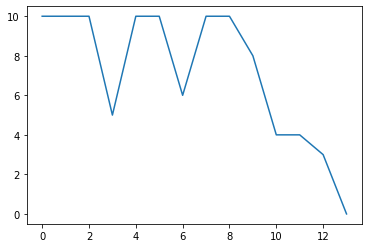

In [78]:
from ACLScheduleTest.data import RandomDsk

rd = RandomDsk(
    mute=True, node_num=100,
    st_node_num=10,
    min_time=1, time_lv=0, time_rv=0, min_time_step=0,
    avg_mem_peek=1, mem_pv=0, mem_sv=1
)
sim = Simulator()
sim.simulate(schedule_in_func, schedule_out_func, mem_bound=50, worker_bound=10, rd=rd)